<center><h2><strong><font color="blue">Natural Language Processing dan Text Mining (NLPTM)</font></strong></h2></center>
<center><h2><strong><font color="blue">Social Media Analytics (SMA)</font></strong></h2></center>

<center><h3><strong><font color="blue"><a href="https://taudata.blogspot.com">https://taudata.blogspot.com</a></font></strong></h3></center>

<img alt="" src="images/covers/taudata-cover.jpg"/>

<center><h2><strong><font color="blue">NLPTM-06: Pendahuluan Sentimen Analysis</font></strong></h2></center>
<center><h3><strong><font color="blue"><a href="https://taudata.blogspot.com/2022/05/nlptm-06.html">https://taudata.blogspot.com/2022/05/nlptm-06.html</a></font></strong></h3></center>
<b><center><h3>(C) Taufik Sutanto ~ taudata Analytics</h3></center>

## <font color="blue">Outline :</font>

* Corpus-Based Sentiment Analysis
* Metode Supervised untuk Sentiment Analysis 

In [1]:
# Jalankan Cell ini "HANYA" jika anda menggunakan Google Colab
# Jika di jalankan di komputer local, silahkan lihat NLPTM-02 untuk instalasinya.
import warnings; warnings.simplefilter('ignore')
import nltk

try:
    import google.colab; IN_COLAB = True
    !wget https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/taudataNlpTm.py
    !mkdir data
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/slang.txt
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/stopwords_id.txt
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/stopwords_en.txt
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/kata_dasar.txt
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/wn-ind-def.tab
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/wn-msa-all.tab
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/ind_SA.csv
    !wget -P data/ https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/data/all_indo_man_tag_corpus_model.crf.tagger

    !pip install spacy python-crfsuite unidecode textblob sastrawi
    !python -m spacy download xx_core_web_sm
    !python -m spacy download en_core_web_sm

    nltk.download('popular')
except:
    IN_COLAB = False
    print("Running the code locally, please make sure all the python module versions agree with colab environment and all data/assets downloaded")

Running the code locally, please make sure all the python module versions agree with colab environment and all data/assets downloaded


In [2]:
# Mulai dengan loading data
import nltk, pickle
from sklearn.datasets import fetch_20newsgroups

try:
    f = open('data/20newsgroups.pckl', 'rb')
    data = pickle.load(f)
    f.close()
except:
    categories = ['sci.med', 'talk.politics.misc',  'rec.autos']
    data = fetch_20newsgroups(categories=categories,remove=('headers', 'footers', 'quotes'))
    f = open('data/20newsgroups.pckl', 'wb')
    pickle.dump(data, f)
    f.close()
'Done'

'Done'

In [3]:
# Merubah data ke bentuk yang biasa kita gunakan
D = [doc for doc in data.data]
Y = data.target
'Done'

'Done'

In [4]:
set(Y)

{0, 1, 2}

In [5]:
D[0]

'I want to get a car alarm and I am thinking about getting an Ungo Box.\n    Does anyone out there have any knowledge or experience with any of\n    these alarms?  How about price ranges for the different models?\n    Are these good car alarms?  Please email me any responces.\n\n                cak3@ns3.lehigh.edu'

In [6]:
# preprocessing
import taudataNlpTm as tau 
from tqdm import tqdm

stops, lemmatizer = tau.LoadStopWords(lang='en')
for i,d in tqdm(enumerate(D)):
    D[i] = tau.cleanText(d, lemma=lemmatizer, stops = stops, symbols_remove = True, min_charLen = 2)
print(D[0])

1653it [28:37,  1.04s/it]

car alarm thinking ungo box knowledge experience alarms price ranges models good car alarms email responces 


In [7]:
# Bentuk VSM-nya
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english',smooth_idf= True, sublinear_tf=True, 
                                   ngram_range=(1, 2), max_df=0.90, min_df=2)

In [8]:
from sklearn.model_selection import train_test_split
seed = 99

x_train, x_test, y_train, y_test = train_test_split(D, Y, test_size=0.3, random_state=seed)
x_train = tfidf_vectorizer.fit_transform(x_train) # "Fit_Transform"
x_test = tfidf_vectorizer.transform(x_test) # Perhatikan disini hanya "Transform"

print(x_train.shape, x_test.shape) # Jumlah kolom Sama ==> ini penting

(1157, 12400) (496, 12400)


In [9]:
# Jangan lupa langkah penting ini! ... 
# Kenapa ada yang kosong?... coba fikirkan ... 
def hapusKosong(X,Y):
    Y = Y[X.getnnz(1)>0] # delete label dokumen yang memiliki row =0 di tfidf-nya
    X = X[X.getnnz(1)>0] # Remove Zero Rows
    return X, Y

x_train, y_train = hapusKosong(x_train, y_train)
x_test, y_test = hapusKosong(x_test, y_test)
print(x_train.shape, x_test.shape)

(1105, 12400) (481, 12400)


In [10]:
# Kita gunakan metric yang umum
from sklearn.metrics import accuracy_score

In [11]:
# Naive Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
nbc = gnb.fit(x_train.toarray(), y_train) # Kelemahan Implementasinya disini

y_nbc = nbc.predict(x_test.toarray())
accuracy_score(y_test, y_nbc)
# Hati-hati Sparse ==> Dense bisa memenuhi memory untuk data relatif cukup besar
# Akurasi cukup baik

0.8690228690228691

In [12]:
# Decision Tree: http://scikit-learn.org/stable/modules/tree.html
from sklearn import tree

DT = tree.DecisionTreeClassifier()
DT = DT.fit(x_train, y_train)

y_DT = DT.predict(x_test)
accuracy_score(y_test, y_DT)
# Akurasi relatif rendah ==> Mengapa?

0.7276507276507277

In [13]:
# Mari coba perbaiki dengan Random Forest
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier

RandomForest = RandomForestClassifier()
RandomForest.fit(x_train, y_train)

y_RF = RandomForest.predict(x_test)
accuracy_score(y_test, y_RF)
# Sedikit membaik (expected)

0.8565488565488566

In [14]:
# SVM: http://scikit-learn.org/stable/modules/svm.html
from sklearn import svm

dSVM = svm.SVC(decision_function_shape='ovo') # oneversus one SVM
dSVM.fit(x_train, y_train)

y_SVM = dSVM.predict(x_test)
accuracy_score(y_test, y_SVM)
# Mengapa akurasinya rendah? Mengejutkan?

0.918918918918919

In [15]:
# Neural Network: http://scikit-learn.org/stable/modules/neural_networks_supervised.html
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier(hidden_layer_sizes=(30, 40))
NN.fit(x_train, y_train)

y_NN = NN.predict(x_test)
accuracy_score(y_test, y_NN)
# Cukup Baik, coba rubah jumlah layer dan Neuron

0.920997920997921

## Tunggu dulu ... yang kita lakukan belum cukup valid/objektif ... Mengapa?


In [16]:
# Cross validation
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
from sklearn.model_selection import cross_val_score
import time

# perhatikan sekarang kita menggunakan seluruh data
# Bisa juga CV di training data ==> train, Test, Val splittting system
X = tfidf_vectorizer.fit_transform(D) # "Fit_Transform"

svm_ = svm.SVC(kernel='linear', decision_function_shape='ovo')
mulai = time.time()
scores_svm = cross_val_score(svm_, X, Y, cv=10, n_jobs=-2) 
waktu = time.time() - mulai
# Interval Akurasi 95 CI 
print("Accuracy SVM: %0.2f (+/- %0.2f), Waktu = %0.3f detik" % (scores_svm.mean(), scores_svm.std() * 2, waktu))

Accuracy SVM: 0.91 (+/- 0.04), Waktu = 2.888 detik


In [17]:
# Bandingkan dengan Neural Network
nn_ = MLPClassifier(hidden_layer_sizes=(30, 40))
mulai = time.time()
scores_nn = cross_val_score(nn_, X, Y, cv=10, n_jobs=-2) 
waktu = time.time() - mulai
# Interval Akurasi 95 CI 
print("Accuracy ANN: %0.2f (+/- %0.2f), Waktu = %0.3f detik" % (scores_nn.mean(), scores_nn.std() * 2, waktu))

Accuracy ANN: 0.92 (+/- 0.05), Waktu = 56.560 detik


In [18]:
# Kita bisa juga mengeluarkan metric evaluasi lainnya
scores = cross_val_score(svm_, X, Y, cv=10, scoring='f1_macro')
print("F1-Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# scoring pilih dari sini: http://scikit-learn.org/stable/modules/model_evaluation.html

F1-Score: 0.91 (+/- 0.04)


In [19]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt; plt.style.use('classic')
import numpy as np, pandas as pd

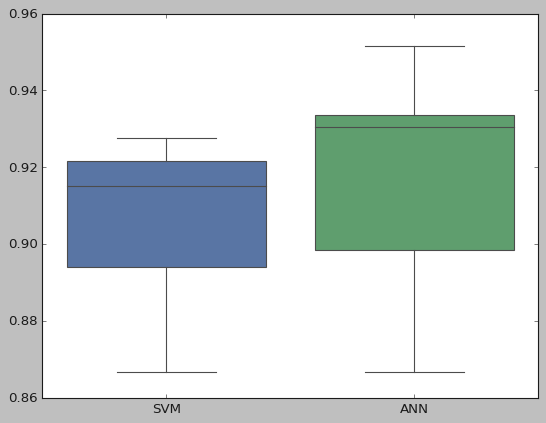

In [20]:
df = pd.DataFrame({'SVM':scores_svm,'ANN':scores_nn})
sns.boxplot(data=df)
plt.show()

<p><strong>Apakah sentiment analysis?</strong></p>

<p>Sentiment Analysis adalah suatu proses komputasi untuk menentukan apakah suatu penrnyataan bermakna positive, negative, atau netral.</p>

<p>Terkadang disebut juga sebagai&nbsp;<strong>opinion mining.</strong></p>

<p><strong>Contoh aplikasi Sentiment Analysis</strong></p>

<ul>
	<li><strong>Business: tanggapan konsumen atas suatu produk</strong>.</li>
	<li><strong>Politics:&nbsp;</strong>Sentimen masyarakat sebagai strategi pemenangan pemilu/pilkada.</li>
</ul>


In [21]:
from textblob import TextBlob
# Lexicon Based berdasarkan 
# pattern = https://www.clips.uantwerpen.be/pages/pattern-en#sentiment
Sentence = "I hate Bakpia"
testimonial = TextBlob(Sentence)
print(testimonial.sentiment)
print('Polarity=Sentimen =', testimonial.sentiment.polarity)

Sentiment(polarity=-0.8, subjectivity=0.9)
Polarity=Sentimen = -0.8


<p>Sentiment menghasilkan Tuple berpasangan (<strong>Polaritas</strong>, <strong>Subjectivitas</strong>).&nbsp;</p>

<p>Polaritas memiliki nilai [-1, 1] ==&gt; negative~positive Sentimen</p>

<p>Subjectivity memiliki nilai antara 0 sampai 1, dimana 0 paling objective dan 1 paling subjective.</p>

## Bagaimana Dengan Bahasa Indonesia?
<p>[A simple trick]</p>

In [22]:
try:
    kalimat = 'Saya suka Bakpia'
    K = TextBlob(kalimat).translate(to='en')
    print(type(K), K)
except:
    K = False
    print("Fungsi ini deprecated di TextBlob. Anda bisa gunakan https://translate.google.com secara manual\
          atau secara automatis dengan menggunakan API-nya")

Fungsi ini deprecated di TextBlob. Anda bisa gunakan https://translate.google.com secara manual          atau secara automatis dengan menggunakan API-nya


In [23]:
if not K:
    K = TextBlob("Bakpia is so delicious")
print(K.sentiment)
print('Polarity=Sentimen =', K.sentiment.polarity)    

Sentiment(polarity=1.0, subjectivity=1.0)
Polarity=Sentimen = 1.0


In [24]:
def SenSubModMood_ID(kalimat):
    K = TextBlob(kalimat).translate(to='en')
    pol,sub = K.sentiment
    if pol>0:
        pol='positive'
    elif pol<0:
        pol='negative'
    else:
        pol = 'netral'
    if sub>0.5:
        sub = 'Subjektif'
    else:
        sub = "Objektif"
    return pol, sub

In [25]:
kalimat = 'makan bakpia pakai kecap enak'
try:
    SenSubModMood_ID(kalimat)
except:
    print("Fungsi ini deprecated di TextBlob. Anda bisa gunakan https://translate.google.com secara manual\
          atau secara automatis dengan menggunakan API-nya")

Fungsi ini deprecated di TextBlob. Anda bisa gunakan https://translate.google.com secara manual          atau secara automatis dengan menggunakan API-nya


In [26]:
from textblob.sentiments import NaiveBayesAnalyzer
# Warning, mungkin lambat karena membentuk model classifier* terlebih dahulu.
# *Berdasarkan NLTK corpus ==> Language dependent
Sentence = "Textblob is amazingly simple to use"
blob = TextBlob(Sentence, analyzer=NaiveBayesAnalyzer())
blob.sentiment
# Good Explanation: https://medium.com/nlpython/sentiment-analysis-analysis-ee5da4448e37
# Output probabilitas prediksinya

Sentiment(classification='pos', p_pos=0.7952586206896557, p_neg=0.2047413793103446)

## Bagaimana dengan Sentiment Analysis menggunakan NBC untuk Bahasa indonesia?

In [27]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
 
def word_feats(words):
    return dict([(word, True) for word in words])

def bentukClassifier(wPos, wNeg): # ,Nt
    positive_features = [(word_feats(pos), 'pos') for pos in wPos]
    negative_features = [(word_feats(neg), 'neg') for neg in wNeg]
    #neutral_features = [(word_feats(neu), 'neu') for neu in Nt]
    train_set = negative_features + positive_features# + neutral_features
    return NaiveBayesClassifier.train(train_set)

def prediksiSentiment(kalimat, wPos, wNeg, negasi):
    pos, neg = 0.0, 0.0
    posWords, negWords = [], []
    K = tau.cleanText(kalimat)
    for w in wPos:
        if w in K:
            for ww in negasi:
                kebalikan = False
                inverted = ww+' '+w
                if inverted in K:
                    negWords.append(inverted)
                    kebalikan = True
                    break
            if not kebalikan:
                posWords.append(w)
    for w in wNeg:
        if w in K:
            for ww in negasi:
                kebalikan = False
                inverted = ww+' '+w
                if inverted in K:
                    posWords.append(inverted)
                    kebalikan = True
                    break
            if not kebalikan:
                negWords.append(w)
    
    nPos, nNeg = len(posWords), len(negWords)
    sum_ = nPos + nNeg
    if sum_ == 0 or nPos==nNeg:
        return 'netral', 0.0
    else:
        nPos, nNeg = nPos/sum_, nNeg/sum_
        if nPos>nNeg and nPos>0.01:
            return 'positif', nPos
        elif nNeg>nPos and nNeg<-0.01:
            return 'negatif', nNeg
        else:
            return 'netral', (nPos + nNeg)/2

In [28]:
wPos = ('keren', 'suka', 'cinta', 'bagus', 'mantap', 'sadis', 'top', 'enak', 'sedap')
wNeg = ('jelek', 'benci','buruk', 'najis')
wordS = (wPos, wNeg)
negasi = ['ga', 'tidak']

In [29]:
sentence = "makan pempek minumnya teh panas, biasa aja :)"
prediksiSentiment(sentence, wPos, wNeg, negasi)

('netral', 0.0)

In [30]:
sentence = "makan gorengan sambil minum kopi, enak tenan"
prediksiSentiment(sentence, wPos, wNeg, negasi)

('positif', 1.0)

## Bagaimana jika mau melakukannya dengan model klasifikasi (supervised learning) lain seperti modul sebelumnya?
(e.g. SVM, NN, DT, k-NN, etc)

In [31]:
# text Classification : independent variable
d1 = 'Minum kopi pagi-pagi sambil makan pisang goreng is the best'
d2 = 'Belajar NLP dan Text Mining ternyata seru banget'
d3 = 'Palembang agak mendung hari ini'
d4 =  'Sudah lumayan lama tukang Bakso belum lewat'
d5 = 'Aduh ga banget makan Mie Ayam pakai kecap, please deh'
d6 = 'Benci banget kalau melihat orang buang sampah sembarangan di jalan'
d7 = 'Kalau liat orang ga taat aturan rasanya ingin ngegampar aja'
d8 = 'Nikmatnya meniti jalan jalan penuh romansa di tengah kota bernuansa pendidikan'
d9 = 'kemajuan bangsa ini ada pada kegigihan masyarakat dalam belajar dan bekerja'
D = [d1,d2,d3,d4,d5,d6,d7,d8,d9]
'Done!'

'Done!'

In [32]:
# dependent variable, misal 0=positif, 1=netral, 2=negatif
Class = [0,0,1,1,2,2,2,1,0]
dic = {0:'positif', 1:'netral', 2:'negatif'}
print([dic[c] for c in Class])

['positif', 'positif', 'netral', 'netral', 'negatif', 'negatif', 'negatif', 'netral', 'positif']


In [33]:
# Bentuk VSM-nya seperti kemarin (skip preprocessing)
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vsm = vectorizer.fit_transform(D)
vsm = vsm[vsm.getnnz(1)>0][:,vsm.getnnz(0)>0] # Remove zero rows and columns
print(vsm.shape)
str(vectorizer.vocabulary_)[:200]

(9, 144)


"{'minum': 91, 'kopi': 65, 'pagi': 104, 'sambil': 122, 'makan': 76, 'pisang': 114, 'goreng': 43, 'is': 51, 'the': 140, 'best': 28, 'minum kopi': 92, 'kopi pagi': 66, 'pagi pagi': 105, 'pagi sambil': 10"

In [34]:
# Lakukan klasifikasi (misal dengan SVM)
dSVM = svm.SVC(kernel='linear')
sen = dSVM.fit(vsm, Class).predict(vsm)
print(accuracy_score(Class, sen))
# Memakai seluruh training data karena sampel yang sangat kecil

1.0


In [35]:
import nltk, warnings; warnings.simplefilter('ignore')
import pandas as pd, taudataNlpTm as tau
from tqdm import tqdm

# Load DataFile CSV
dataSA = pd.read_csv('data/ind_SA.csv') # run locally
dataSA.head(), dataSA.shape

(   sentimen                                              Tweet
 0        -1  lagu bosan apa yang aku save ni huhuhuhuhuhuhu...
 1        -1  kita lanjutkan saja diam ini hingga kau dan ak...
 2         1  doa rezeki tak putus inna haa zaa larizquna ma...
 3         1  makasih loh ntar kita bagi hasil aku 99 9 sisa...
 4        -1  aku tak faham betul jenis orang malaysia yang ...,
 (10806, 2))

In [36]:
dataSA['tweet_cleaned'] = ''
dataSA.head()

,sentimen,Tweet,tweet_cleaned
0,-1,lagu bosan apa yang aku save ni huhuhuhuhuhuhu...,
1,-1,kita lanjutkan saja diam ini hingga kau dan ak...,
2,1,doa rezeki tak putus inna haa zaa larizquna ma...,
3,1,makasih loh ntar kita bagi hasil aku 99 9 sisa...,
4,-1,aku tak faham betul jenis orang malaysia yang ...,


# PreProcessing

### Detail lebih lanjut di 

* https://taudata.blogspot.com/2020/04/nlptm-01.html
* https://taudata.blogspot.com/2020/04/nlptm-02.html
* https://taudata.blogspot.com/2022/04/nlptm-03.html

In [37]:
stopId, lemmaId = tau.LoadStopWords(lang='id') 
for i, d in tqdm(dataSA.iterrows()):
    doc = tau.cleanText(d.Tweet, lemma=lemmaId, stops = None, symbols_remove = True, min_charLen = 2, fixTag= True)
    dataSA.at[i, "tweet_cleaned"] = doc
    
dataSA.head()

10806it [13:27, 13.38it/s]


,sentimen,Tweet,tweet_cleaned
0,-1,lagu bosan apa yang aku save ni huhuhuhuhuhuhu...,lagu bosan apa yang aku save ni huhuhuhuhuhuhu...
1,-1,kita lanjutkan saja diam ini hingga kau dan ak...,kita lanjut saja diam ini hingga kau dan aku e...
2,1,doa rezeki tak putus inna haa zaa larizquna ma...,doa rezeki tak putus inna haa zaa larizquna ma...
3,1,makasih loh ntar kita bagi hasil aku 99 9 sisa...,makasih loh ntar kita bagi hasil aku sisa buat...
4,-1,aku tak faham betul jenis orang malaysia yang ...,aku tak faham betul jenis orang malaysia yang ...


In [38]:
from sklearn.model_selection import train_test_split

seed = 99 # Biasakan menggunakan ini
testSize = 0.2

x_train, x_test, y_train, y_test = train_test_split(dataSA["tweet_cleaned"], dataSA["sentimen"], 
                                                    test_size=testSize, random_state = seed)
print(x_train.shape, x_test.shape)

(8644,) (2162,)


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

vsm = TfidfVectorizer(lowercase=True, smooth_idf= True, sublinear_tf=True, 
                                   ngram_range=(1, 2), max_df=0.90, min_df=2)

x_train = vsm.fit_transform(x_train) # "Fit_Transform"
x_test = vsm.transform(x_test) # Perhatikan disini hanya "Transform"

print(x_train.shape, x_test.shape) # Jumlah kolom Sama ==> ini penting

(8644, 19639) (2162, 19639)


# Document Classification ~ Sentiment Analysis

* https://taudata.blogspot.com/2020/04/slcm-01.html
* https://taudata.blogspot.com/2020/04/slcm-02.html
* https://taudata.blogspot.com/2022/04/slcm-03.html

In [40]:
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report


model = neighbors.KNeighborsClassifier()
kNN = model.fit(x_train, y_train)
y_kNN = kNN.predict(x_test)

print('Akurasi = ', accuracy_score(y_test, y_kNN))
print(confusion_matrix(y_test, y_kNN))
print(classification_report(y_test, y_kNN))

Akurasi =  0.4750231267345051
[[ 77 399  85]
 [ 71 818 214]
 [ 25 341 132]]
              precision    recall  f1-score   support

          -1       0.45      0.14      0.21       561
           0       0.53      0.74      0.61      1103
           1       0.31      0.27      0.28       498

    accuracy                           0.48      2162
   macro avg       0.43      0.38      0.37      2162
weighted avg       0.45      0.48      0.43      2162



In [41]:
from sklearn import svm

dSVM = svm.SVC()
dSVM.fit(x_train, y_train)
y_SVM = dSVM.predict(x_test)
print('Akurasi = ', accuracy_score(y_test, y_SVM))
print(confusion_matrix(y_test, y_SVM))
print(classification_report(y_test, y_SVM))

Akurasi =  0.6151711378353376
[[192 343  26]
 [ 82 970  51]
 [ 54 276 168]]
              precision    recall  f1-score   support

          -1       0.59      0.34      0.43       561
           0       0.61      0.88      0.72      1103
           1       0.69      0.34      0.45       498

    accuracy                           0.62      2162
   macro avg       0.63      0.52      0.53      2162
weighted avg       0.62      0.62      0.58      2162



In [42]:
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier()
NN.fit(x_train, y_train)
y_NN = NN.predict(x_test)

print('Akurasi = ', accuracy_score(y_test, y_NN))
print(confusion_matrix(y_test, y_NN))
print(classification_report(y_test, y_NN))

Akurasi =  0.5698427382053654
[[269 198  94]
 [201 727 175]
 [ 71 191 236]]
              precision    recall  f1-score   support

          -1       0.50      0.48      0.49       561
           0       0.65      0.66      0.66      1103
           1       0.47      0.47      0.47       498

    accuracy                           0.57      2162
   macro avg       0.54      0.54      0.54      2162
weighted avg       0.57      0.57      0.57      2162



In [43]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline 

In [44]:
# Optimal parameter k-NN dengan GRIDSEARCH
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

x_train, x_test, y_train, y_test = train_test_split(dataSA["tweet_cleaned"], dataSA["sentimen"], 
                                                    test_size=testSize, random_state = seed)
# Perhatikan kita pakai data awal : Text karena kita akan optimalkan preprocessing juga

kCV = 5
metric = 'accuracy'
params = {}
params['tfidfvectorizer__min_df'] = [5, 10, 15]
params['tfidfvectorizer__max_df'] = [0.5, 0.75, 0.95]
params['tfidfvectorizer__smooth_idf'] = [True] # [True, False]
params['tfidfvectorizer__sublinear_tf'] = [True] # [True, False]
params['tfidfvectorizer__ngram_range'] = [(1, 1), (1, 2), (1,3)]
params['kneighborsclassifier__n_neighbors'] = [3, 5, 10]
params['kneighborsclassifier__weights'] = ('distance', 'uniform')

pipe = make_pipeline(TfidfVectorizer(), neighbors.KNeighborsClassifier())
gridCV = GridSearchCV(pipe, params, cv=kCV, scoring=metric, verbose=1, n_jobs=-1) # , pre_dispatch='2*n_jobs', pre_dispatch min 2* n_jobs
gridCV.fit(x_train, y_train)
print(gridCV.best_score_)
print(gridCV.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
0.46494802711907973
{'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'distance', 'tfidfvectorizer__max_df': 0.5, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__smooth_idf': True, 'tfidfvectorizer__sublinear_tf': True}


In [45]:
# Optimal parameter SVM dengan RandomSEARCH
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

pipeSVM = make_pipeline(TfidfVectorizer(), svm.SVC())
print(sorted(pipeSVM.get_params().keys()))

['memory', 'steps', 'svc', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose', 'tfidfvectorizer', 'tfidfvectorizer__analyzer', 'tfidfvectorizer__binary', 'tfidfvectorizer__decode_error', 'tfidfvectorizer__dtype', 'tfidfvectorizer__encoding', 'tfidfvectorizer__input', 'tfidfvectorizer__lowercase', 'tfidfvectorizer__max_df', 'tfidfvectorizer__max_features', 'tfidfvectorizer__min_df', 'tfidfvectorizer__ngram_range', 'tfidfvectorizer__norm', 'tfidfvectorizer__preprocessor', 'tfidfvectorizer__smooth_idf', 'tfidfvectorizer__stop_words', 'tfidfvectorizer__strip_accents', 'tfidfvectorizer__sublinear_tf', 'tfidfvectorizer__token_pattern', 'tfidfvectorizer__tokenizer', 'tfidfvectorizer__use_idf', 'tfidfvectorizer__vocabulary', 'verbose']


In [46]:
# Optimal parameter SVM dengan RandomizedSearch

paramsSVM = {}
paramsSVM['tfidfvectorizer__min_df'] = [5, 10, 30]
paramsSVM['tfidfvectorizer__max_df'] = [0.5, 0.75, 0.95]
paramsSVM['tfidfvectorizer__smooth_idf'] = [True] # [True, False]
paramsSVM['tfidfvectorizer__sublinear_tf'] = [True] # [True, False]
paramsSVM['tfidfvectorizer__ngram_range'] = [(1, 1), (1, 2), (1,3)]
paramsSVM['svc__C'] = [0.1, 10, 100] #sp.stats.uniform(scale=1)
paramsSVM['svc__gamma'] = [1.0, 0.1, 0.001]
paramsSVM['svc__kernel'] = ['rbf', 'poly', 'sigmoid', 'linear']
paramsSVM['svc__decision_function_shape'] = ['ovo', 'ovr']

randsvmCV = RandomizedSearchCV(pipeSVM, paramsSVM, cv=kCV, scoring=metric, verbose=1, n_iter=30, random_state=seed, n_jobs=-1) # , pre_dispatch='2*n_jobs' pre_dispatch min 2* n_jobs
randsvmCV.fit(x_train, y_train)
print(randsvmCV.best_score_)
print(randsvmCV.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
0.6074721392155603
{'tfidfvectorizer__sublinear_tf': True, 'tfidfvectorizer__smooth_idf': True, 'tfidfvectorizer__ngram_range': (1, 3), 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__max_df': 0.75, 'svc__kernel': 'rbf', 'svc__gamma': 1.0, 'svc__decision_function_shape': 'ovr', 'svc__C': 10}


In [47]:
# Optimal parameter ANN dengan RandomSEARCH
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

pipeNN = make_pipeline(TfidfVectorizer(), MLPClassifier())
print(sorted(pipeNN.get_params().keys()))

['memory', 'mlpclassifier', 'mlpclassifier__activation', 'mlpclassifier__alpha', 'mlpclassifier__batch_size', 'mlpclassifier__beta_1', 'mlpclassifier__beta_2', 'mlpclassifier__early_stopping', 'mlpclassifier__epsilon', 'mlpclassifier__hidden_layer_sizes', 'mlpclassifier__learning_rate', 'mlpclassifier__learning_rate_init', 'mlpclassifier__max_fun', 'mlpclassifier__max_iter', 'mlpclassifier__momentum', 'mlpclassifier__n_iter_no_change', 'mlpclassifier__nesterovs_momentum', 'mlpclassifier__power_t', 'mlpclassifier__random_state', 'mlpclassifier__shuffle', 'mlpclassifier__solver', 'mlpclassifier__tol', 'mlpclassifier__validation_fraction', 'mlpclassifier__verbose', 'mlpclassifier__warm_start', 'steps', 'tfidfvectorizer', 'tfidfvectorizer__analyzer', 'tfidfvectorizer__binary', 'tfidfvectorizer__decode_error', 'tfidfvectorizer__dtype', 'tfidfvectorizer__encoding', 'tfidfvectorizer__input', 'tfidfvectorizer__lowercase', 'tfidfvectorizer__max_df', 'tfidfvectorizer__max_features', 'tfidfvector

In [48]:
paramsNN = {}
paramsNN['tfidfvectorizer__min_df'] = [5, 10, 30]
paramsNN['tfidfvectorizer__max_df'] = [0.5, 0.75, 0.95]
paramsNN['tfidfvectorizer__smooth_idf'] = [True] # [True, False]
paramsNN['tfidfvectorizer__sublinear_tf'] = [True] # [True, False]
paramsNN['tfidfvectorizer__ngram_range'] = [(1, 1), (1, 2), (1,3)]
paramsNN['mlpclassifier__hidden_layer_sizes'] = [(5,10), (20,30), (30,50)] 
paramsNN['mlpclassifier__learning_rate'] = ['constant', 'invscaling', 'adaptive']
paramsNN['mlpclassifier__activation'] = ['logistic', 'tanh', 'relu' ]

randNnCV = RandomizedSearchCV(pipeNN, paramsNN, cv=kCV, scoring=metric, verbose=1, n_iter=30, random_state=seed, n_jobs=-1) # , pre_dispatch='2*n_jobs' pre_dispatch min 2* n_jobs
randNnCV.fit(x_train, y_train)
print(randNnCV.best_score_)
print(randNnCV.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
0.5800556412398518
{'tfidfvectorizer__sublinear_tf': True, 'tfidfvectorizer__smooth_idf': True, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__min_df': 30, 'tfidfvectorizer__max_df': 0.75, 'mlpclassifier__learning_rate': 'constant', 'mlpclassifier__hidden_layer_sizes': (5, 10), 'mlpclassifier__activation': 'logistic'}


In [49]:
knn_score = gridCV.cv_results_['mean_test_score'][:10]
svm_score = randsvmCV.cv_results_['mean_test_score'][:10]
ann_score = randNnCV.cv_results_['mean_test_score'][:10]
ann_score

array([0.54639001, 0.53840772, 0.51827639, 0.55460453, 0.52359933,
       0.53030982, 0.55448838, 0.53563148, 0.54268852, 0.52221205])

Accuracy kNN: 0.39 (+/- 0.06)
Accuracy SVM: 0.53 (+/- 0.09)
Accuracy NN: 0.54 (+/- 0.02)


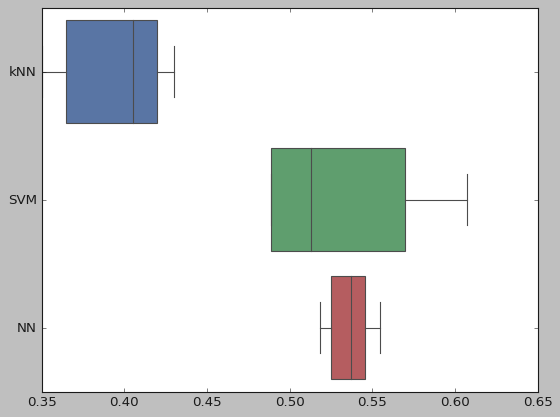

In [50]:
import seaborn as sns, matplotlib.pyplot as plt

models = ['kNN', 'SVM', 'NN']
scores = [knn_score, svm_score, ann_score]

data = {m:s for m,s in zip(models, scores)}
for name in data.keys():
    print("Accuracy %s: %0.2f (+/- %0.2f)" % (name, data[name].mean(), data[name].std() * 2))

sns.boxplot(data=pd.DataFrame(data), orient='h')
plt.show()

## “meta-algorithms” : Bagging & Boosting
* Ensemble https://www.youtube.com/watch?v=Un9zObFjBH0 
* Bagging https://www.youtube.com/watch?v=2Mg8QD0F1dQ 
* Boosting https://www.youtube.com/watch?v=GM3CDQfQ4sw

In [51]:
# Contoh Voting (Bagging) di Python
# Kita menggunakan semua parameter optimal dari langkah sebelumnya
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier

x_train, x_test, y_train, y_test = train_test_split(dataSA["tweet_cleaned"], dataSA["sentimen"], 
                                                    test_size=testSize, random_state = seed)
                                                    
vsm = TfidfVectorizer(lowercase=True, smooth_idf= True, sublinear_tf=True, 
                                   ngram_range=(1, 1), max_df=0.95, min_df=10)

x_train = vsm.fit_transform(x_train) # "Fit_Transform"
x_test = vsm.transform(x_test) # Perhatikan disini hanya "Transform"

kNN = neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance')
SVM = svm.SVC(C=0.1, gamma=1, kernel='rbf', decision_function_shape='ovr')
ann = MLPClassifier(hidden_layer_sizes=(5, 10), learning_rate='invscaling', activation='logistic')

ensemble = VotingClassifier(estimators=[('k-NN', kNN), ('SVM', SVM), ('ANN', ann)], voting='hard')
ensemble.fit(x_train, y_train)
y_ens = ensemble.score(x_test, y_test)

print('Akurasi k-NN = ', gridCV.best_score_)
print('Akurasi SVM = ', randsvmCV.best_score_)
print('Akurasi ANN = ', randNnCV.best_score_)
print('Akurasi Ensemble = ', y_ens)

Akurasi k-NN =  0.46494802711907973
Akurasi SVM =  0.6074721392155603
Akurasi ANN =  0.5800556412398518
Akurasi Ensemble =  0.562904717853839


In [52]:
kNN = neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance')
SVM = svm.SVC(C=0.1, gamma=1, kernel='rbf', decision_function_shape='ovr', probability=True)
ann = MLPClassifier(hidden_layer_sizes=(5, 10), learning_rate='invscaling', activation='logistic')

ensemble = VotingClassifier(estimators=[('k-NN', kNN), ('SVM', SVM), ('ANN', ann)], voting='soft')
ensemble.fit(x_train, y_train)
y_ens = ensemble.score(x_test, y_test)

print('Akurasi k-NN = ', gridCV.best_score_)
print('Akurasi SVM = ', randsvmCV.best_score_)
print('Akurasi ANN = ', randNnCV.best_score_)
print('Akurasi Ensemble = ', y_ens)

Akurasi k-NN =  0.46494802711907973
Akurasi SVM =  0.6074721392155603
Akurasi ANN =  0.5800556412398518
Akurasi Ensemble =  0.6086956521739131


[[2140  145   41]
 [  65 4095   64]
 [  42  158 1894]]


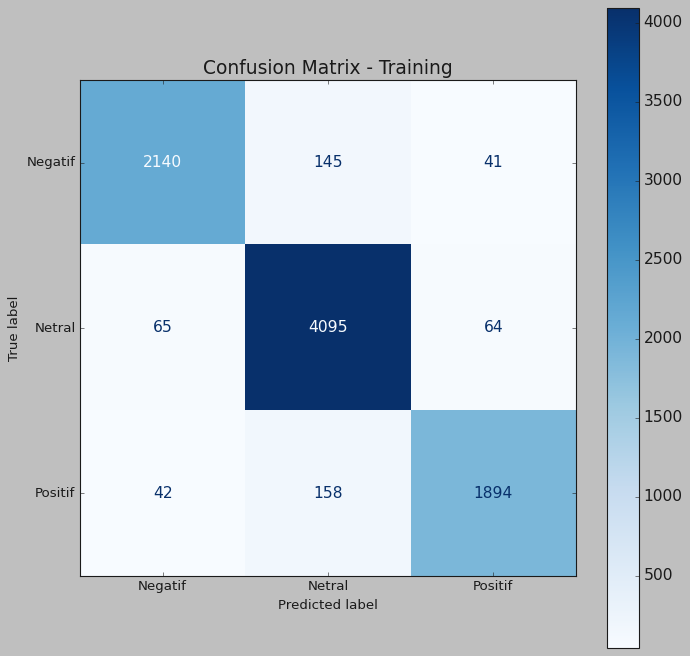

In [53]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 14})
class_names = ["Negatif", "Netral", "Positif"]
disp = plot_confusion_matrix(ensemble, x_train, y_train, display_labels=class_names, cmap=plt.cm.Blues, ax=ax)# , normalize='true'
disp.ax_.set_title("Confusion Matrix - Training")
print(disp.confusion_matrix)

In [54]:
# Compared to training error to make sure overfitting not happening
ensemble_pred = ensemble.predict(x_test)
print(classification_report(y_test, ensemble_pred))

              precision    recall  f1-score   support

          -1       0.60      0.38      0.46       561
           0       0.64      0.77      0.70      1103
           1       0.52      0.50      0.51       498

    accuracy                           0.61      2162
   macro avg       0.59      0.55      0.56      2162
weighted avg       0.60      0.61      0.60      2162



# End of Module

<hr />
<p><img alt="" src="images/meme-cartoon/6_ML_Class.jpg" style="height:495px; width:640px" /></p>
